O exemplo a seguir pode ser util para análisar dados em dataframes pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def resample_uniform(df, time_col, value_col, method="linear"):
    """
    Constrói um novo DataFrame com amostragem uniforme a partir de
    dados irregulares via interpolação 1-D.
    """
    t = df[time_col].to_numpy() / 1000.0
    x = df[value_col].to_numpy()

    # passo alvo = mediana do passo observado (robusto a outliers)
    dt_target = np.median(np.diff(np.sort(t)))
    t_uniform = np.arange(t.min(), t.max(), dt_target)

    if method == "linear":
        x_uniform = np.interp(t_uniform, t, x)          # interp1d simples
    else:
        from scipy.interpolate import interp1d
        f = interp1d(t, x, kind=method, fill_value="extrapolate")
        x_uniform = f(t_uniform)

    return pd.DataFrame({time_col: t_uniform, value_col: x_uniform})


def plot_fft(df, time_col, value_col, detrend=True, show=True):
    """
    Compute and plot the single-sided amplitude spectrum of a time-series stored in a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        Data containing the time and value columns.
    time_col : str
        Name of the column holding the time stamps (seconds or any uniform spacing).
    value_col : str
        Name of the column holding the observed signal values.
    detrend : bool, optional
        If True, remove mean before FFT. Default True.
    show : bool, optional
        If True, displays the plot; otherwise returns the figure object.

    Returns
    -------
    freqs : np.ndarray
        One-sided frequency vector (Hz).
    spectrum : np.ndarray
        Corresponding amplitude spectrum.
    """
    t = df[time_col].values
    x = df[value_col].values

    # Ensure time is sorted
    sort_idx = np.argsort(t)
    t = t[sort_idx]
    x = x[sort_idx]

    # Check uniform sampling
    dt = np.diff(t)
    if not np.allclose(dt, dt[0]):
        raise ValueError("Time vector is not uniformly sampled.")
    Fs = 1.0 / dt[0]  # Sampling frequency

    if detrend:
        x = x - np.mean(x)

    N = len(x)
    # Next power of two for efficient FFT computation
    Nfft = int(2 ** np.ceil(np.log2(N)))

    # Compute FFT using numpy's rfft for real signals (one‑sided)
    Xf = np.fft.rfft(x, n=Nfft) / N
    freqs = np.fft.rfftfreq(Nfft, d=1 / Fs)
    spectrum = np.abs(Xf)

    # ------- figura lado a lado ------- #
    fig, (ax_time, ax_freq) = plt.subplots(1, 2, figsize=(11, 4))

    # Série temporal
    ax_time.plot(t, x)
    ax_time.set_xlabel("Tempo [s]")
    ax_time.set_ylabel("Amplitude")
    ax_time.set_title(value_col)
    ax_time.grid(alpha=0.3)

    # Espectro FFT
    ax_freq.plot(freqs, spectrum)
    ax_freq.set_xlabel("Frequência [Hz]")
    ax_freq.set_ylabel("Amplitude")
    ax_freq.set_title("Espectro (FFT)")
    ax_freq.grid(alpha=0.3)

    if show:
        plt.show()
        return None
    return freqs, spectrum, fig


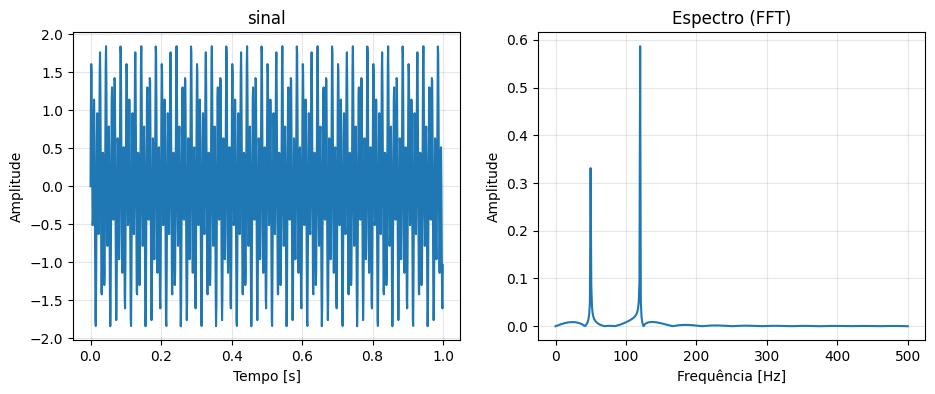

In [2]:
# Gera um sinal sintético: 50 Hz e 120 Hz
t = np.linspace(0, 1, 1000, endpoint=False)
x = 0.7*np.sin(2*np.pi*50*t) + 1.2*np.sin(2*np.pi*120*t)
df_demo = pd.DataFrame({"tempo": t, "sinal": x})

plot_fft(df_demo, "tempo", "sinal")